# ***Tarea 9.KMeans & Shap***
### Luis Eduardo Jiménez del Muro - 01/05/2025
---

# *Paqueterías*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import shap

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:,.4f}'.format)

plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['figure.facecolor'] = 'lightgray'

c:\Users\epile\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# *Funciones*

In [2]:
"""
Grafica de calibración
--------------------------------------------------------------------------------------------------------
"""
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3, ls='--')
    plt.legend(fontsize=12, loc='best')
    plt.show()


"""
Roc Curve
--------------------------------------------------------------------------------------------------------
"""
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)

    plt.title('ROC Curve', fontsize=16, fontweight='bold')
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Histograma de probabilidades
--------------------------------------------------------------------------------------------------------
"""
def histograma(probabilidades, y):
    resultados = pd.DataFrame({'y':y, 'probabilidades': probabilidades})

    sns.histplot(resultados[resultados['y'] == 0]['probabilidades'], stat='density', 
                 color='seagreen', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
    sns.histplot(resultados[resultados['y'] == 1]['probabilidades'], stat='density', 
                 color='cadetblue', alpha=0.65, kde=True, bins=20, edgecolor=None, label='1')
    plt.title('Histograma de probabilidades', fontsize=16, fontweight='bold')
    plt.legend(loc='best')
    plt.xlabel('Probabilidades')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Importance Plot
--------------------------------------------------------------------------------------------------------
"""
def importance_plot(features, importance, type, n_features=10):
    df_importancia = pd.DataFrame({
        'features': features, 
        'importance': importance}).sort_values(by='importance', ascending=True)
    
    plt.barh(df_importancia['features'].tail(n_features), df_importancia['importance'].tail(n_features), 
             color='cadetblue', zorder=2, height=0.4)
    for i, v in enumerate(df_importancia['importance'].tail(n_features)):
        plt.text(v, i, f'{v:.4f}', color='black', fontsize=10)
    plt.title(f'{type}', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--', axis='x', zorder=0)
    plt.show()


"""
Plot Resultados
--------------------------------------------------------------------------------------------------------
"""
def plot_results(probabilidades, y, bins):
    calibracion(probabilidades, y, bins)
    histograma(probabilidades, y)
    roc_curve_graph(probabilidades, y)

In [3]:
"""
Ajuste de XGBoost
--------------------------------------------------------------------------------------------------------
"""
def xgboost(X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': [100_000],
        'max_depth': [1, 2, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.1, 1],
        'tree_method': ['hist'],
        'eval_metric': ['auc']
    }

    model = XGBClassifier(eval_metric='auc', n_jobs=-1, random_state=42,early_stopping_rounds=20)

    xgb_grid = GridSearchCV(estimator=model, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
    xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

    best_model = xgb_grid.best_estimator_
    predicciones = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    weight = best_model.get_booster().get_score(importance_type='weight')
    gain = best_model.get_booster().get_score(importance_type='gain')

    print(f'Best parameters:')
    display(xgb_grid.best_params_)
    return best_model, predicciones, auc, weight, gain

# *Preparar los datos*

In [4]:
data = pd.read_csv('data/titanic.csv')
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data = pd.get_dummies(data)
data = data.drop(columns=['Sex_female'])
target = 'Survived'

X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# *XGBoost*

Best parameters:


{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 100000,
 'reg_lambda': 0.1,
 'tree_method': 'hist'}

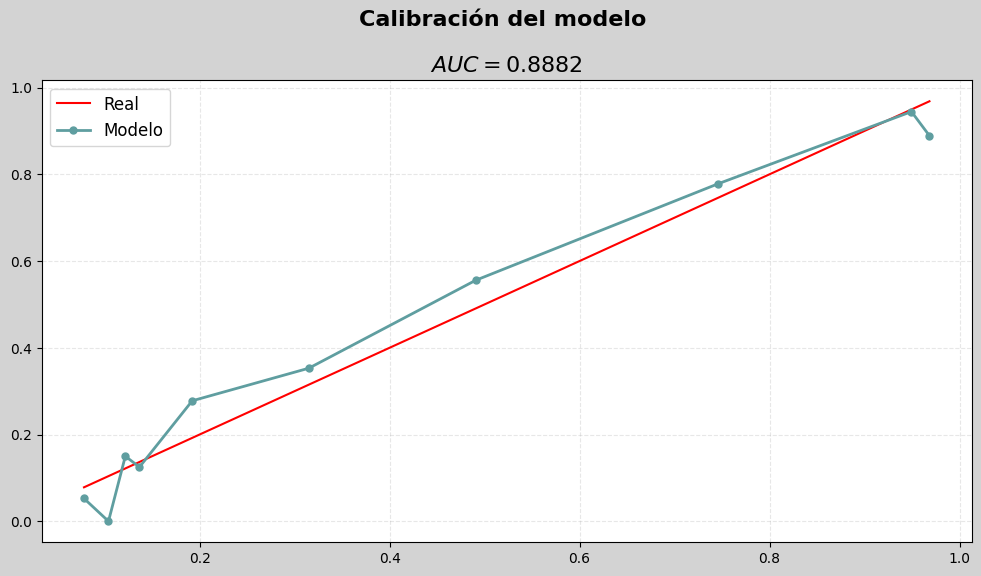

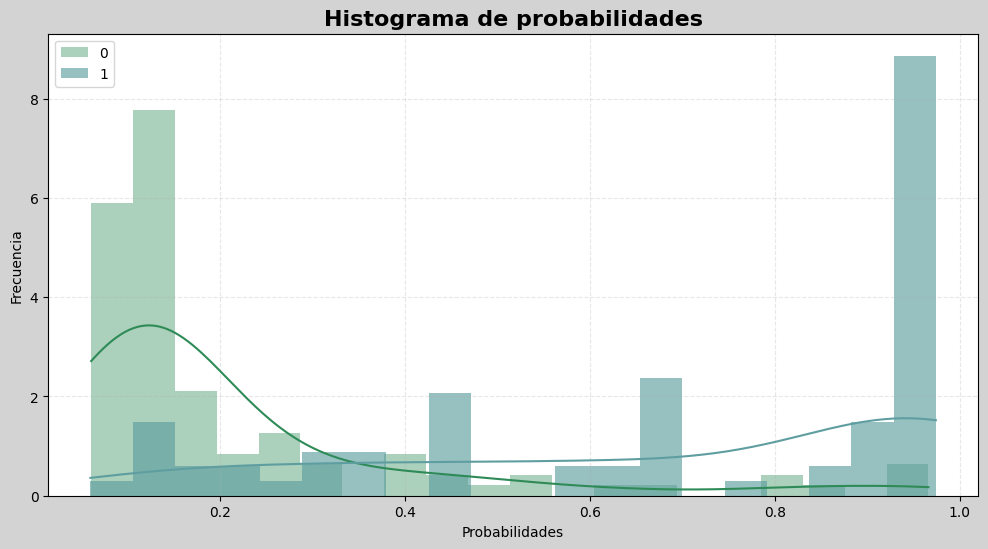

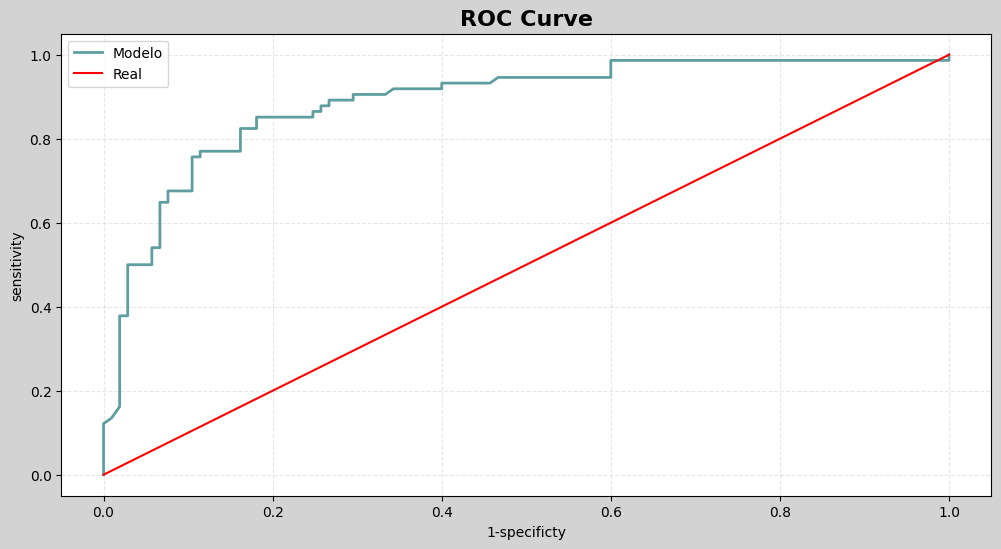

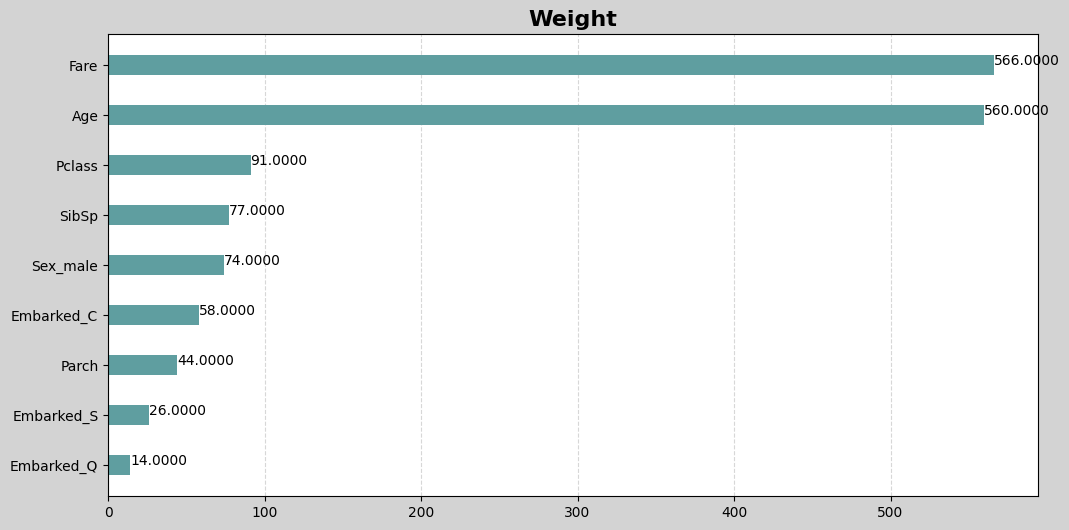

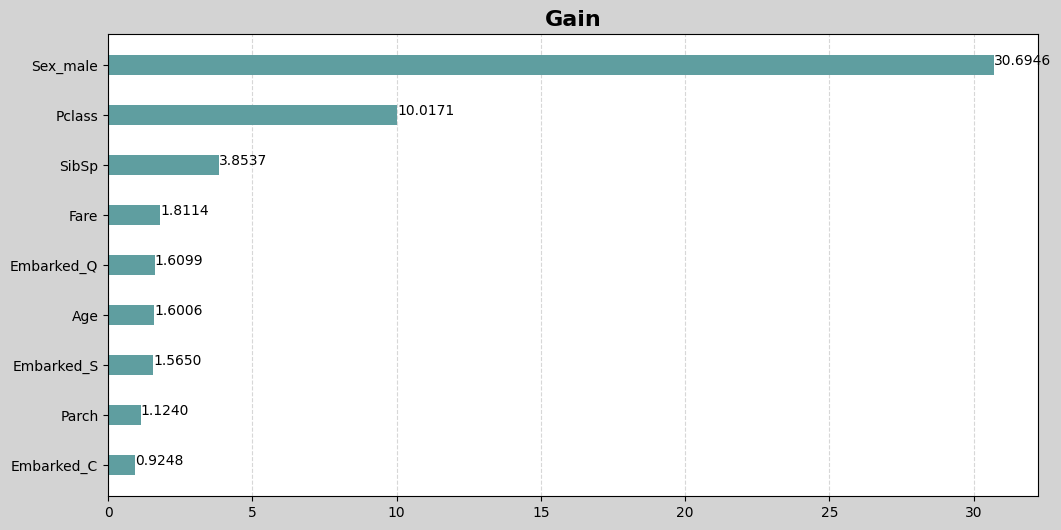

In [5]:
model, predicciones, auc, weight, gain = xgboost(X_train, y_train, X_test, y_test)
plot_results(predicciones, y_test, bins=10)
importance_plot(X_train.columns, weight.values(), 'Weight')
importance_plot(X_train.columns, gain.values(), 'Gain')

# *Shap values para una predicción en el conjunto de prueba*

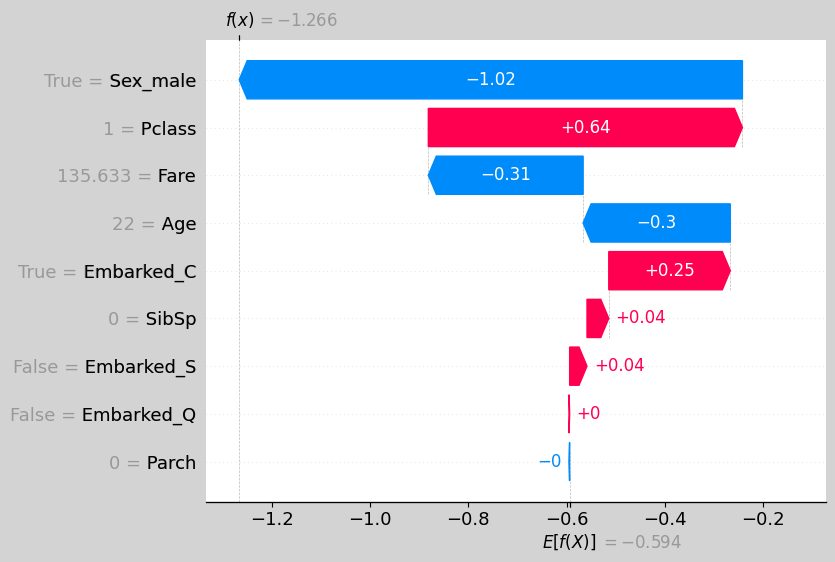

In [54]:
X_shap = X_train.copy()
X_shap = X_train.sample(100, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.initjs()
plt.figure()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_shap.iloc[0], 
    feature_names=X_shap.keys()
))

# *Shap values generales*

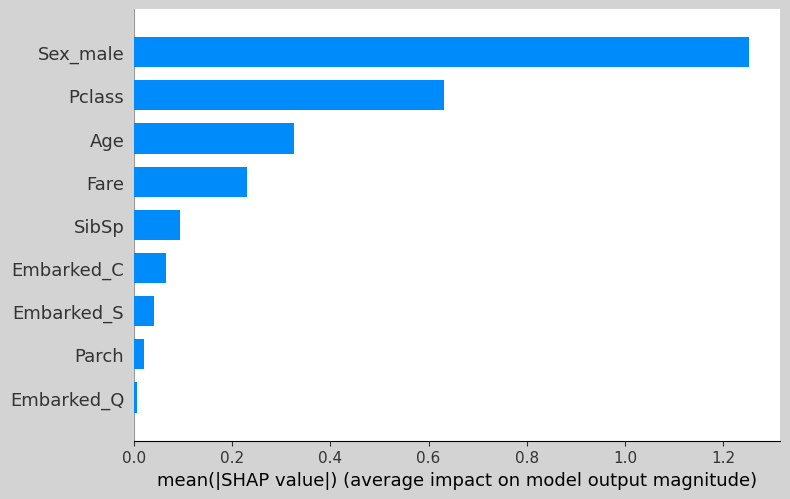

In [62]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

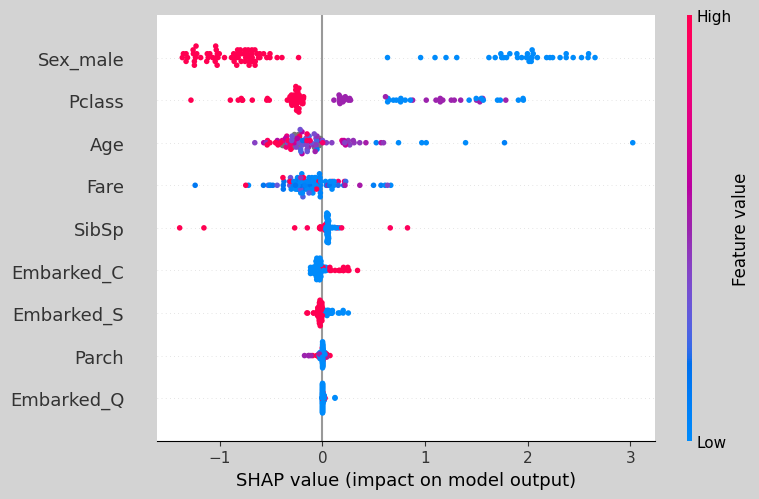

In [64]:
shap.summary_plot(shap_values, X_shap, plot_type='dot', max_display=10)

# *KMeans*

# *Método del codo, ¿cuántos clusters?*

# *Características del cluster*